In [1]:
%load_ext Cython

In [2]:
%matplotlib inline
import matplotlib.pyplot as plot
import seaborn as sns
import numpy as np
import keras as ks

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
import keras.backend as K

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/Users/ifilonov/Library/Python/3.7/lib/python/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/Users/ifilonov/Library/Python/3.7/lib/python/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/Users/ifilonov/Library/Python/3.7/lib/pytho

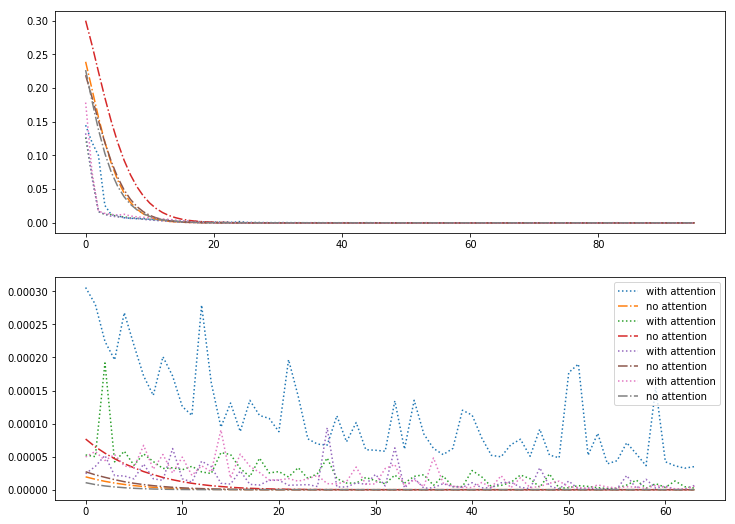

In [4]:
X = np.random.random_sample((10000, 16))
y = X[:, 5] + X[:, 11]

def build_model(w, with_att=False):
    inp = ks.Input((w,))
    net = inp
    if with_att:
        att = inp
        q = ks.layers.Dense(w)(att)
        k = ks.layers.Dense(w)(att)
        v = ks.layers.Dense(w)(att)

        qk = ks.layers.multiply([q, k])
        net = ks.layers.multiply([v, ks.layers.Softmax()(qk)])
    net = ks.layers.Dense(1, 
                          kernel_regularizer = ks.regularizers.l1(1e-8),
                          #activation = 'relu'
                         )(net)
    model = ks.Model(inp, net)
    model.compile('nadam', 'mse')
    return model

xtrain, xval, ytrain, yval = train_test_split(X, y, test_size=0.1, random_state=1)

ks.backend.clear_session()
plot.figure(figsize=(12, 9))
for _ in range(4):
    for n,a in enumerate([True, False]):
        model = build_model(X.shape[1], a)
        r = []
        for i in range(32 * 3):
            model.fit(xtrain, ytrain, epochs=1, batch_size=128, verbose=0)
            r.append(mean_squared_error(yval, model.predict(xval)))
        plot.subplot(211)
        plot.plot(np.log1p(r), ls=':' if a else '-.', label='%s attention'%("with" if a else "no"))
        plot.subplot(212)
        plot.plot(np.log1p(r[32:]), ls=':' if a else '-.', label='%s attention'%("with" if a else "no"))
        plot.legend();
plot.show();

In [14]:
import torch as t

class Mdl(t.nn.Module):
    def __init__(self, D_in):
        super(Mdl, self).__init__()
        self.attq = t.nn.Linear(D_in, D_in)
        self.attk = t.nn.Linear(D_in, D_in)
        self.attv = t.nn.Linear(D_in, D_in)
        self.out = t.nn.Linear(D_in, 1)
        self.sm = t.nn.Softmax(dim=1)

    def forward(self, x):
#        x = self.sm(self.attk(x) * self.attq(x)) * self.attv(x)
        x = self.sm(self.attk(x)) * self.attv(x)
        return self.out(x)
X = t.randn((10000, 32))
def toy(X):
    return X[:, 5] * X[:, 3]
y = toy(X)
X2 = t.randn((10000, 32))
y2 = toy(X2).reshape(-1, 1)
model = Mdl(32)
losser = t.nn.MSELoss()
opt = t.optim.SGD(model.parameters(), lr=0.001, momentum=0.99)
#opt = t.optim.Adam(model.parameters())

print(model)
for e in range(500):
    for b in range(100):
        opt.zero_grad()
        pred = model(X[b*100:b*100+100, :])
        true = y[b*100:b*100+100].reshape(-1, 1)
        l2 = t.tensor(0.)
        for p in model.parameters():
            l2 += t.norm(p) #** 2
        loss = losser(pred, true) + 1e-7 * l2
        loss.backward()
        opt.step()
    if (e + 1) % 50 == 0:
        print('epoch {}: loss {}'.format(e, losser(model(X2), y2).item()))

Mdl(
  (attq): Linear(in_features=32, out_features=32, bias=True)
  (attk): Linear(in_features=32, out_features=32, bias=True)
  (attv): Linear(in_features=32, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
  (sm): Softmax()
)
epoch 49: loss 0.0030423190910369158
epoch 99: loss 0.0011715475702658296
epoch 149: loss 0.0007228737813420594
epoch 199: loss 0.0005169521900825202
epoch 249: loss 0.00039964920142665505
epoch 299: loss 0.0003239937068428844
epoch 349: loss 0.00027120806043967605
epoch 399: loss 0.0002323519001947716
epoch 449: loss 0.00020262041653040797
epoch 499: loss 0.00017919580568559468


In [13]:
class NAC(t.nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.n_in, self.n_out = n_in, n_out
        self.W = t.nn.parameter.Parameter(t.Tensor(n_out, n_in))
        self.M = t.nn.parameter.Parameter(t.Tensor(n_out, n_in))
        self.register_parameter('W', self.W)
        self.register_parameter('M', self.M)

        t.nn.init.kaiming_uniform_(self.W)
        t.nn.init.kaiming_uniform_(self.M)
        
    def forward(self, x):
        W = t.tanh(self.W) * t.sigmoid(self.M)
        return t.nn.functional.linear(x, W)
    
    def extra_repr(self):
        return 'n_in={n_in}, n_out={n_out}'.format(**self.__dict__)
    
class NALU(t.nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.n_in, self.n_out = n_in, n_out
        self.eps = 1e-9

        self.G = t.nn.parameter.Parameter(t.Tensor(n_out, n_in))
        t.nn.init.kaiming_uniform_(self.G, a=np.sqrt(5))
        
        self.nac = NAC(n_in, n_out)
        
    def forward(self, x):
        a = self.nac(x)
        g = t.sigmoid(t.nn.functional.linear(x, self.G))
        lx = t.log(t.abs(x) + self.eps)
        m = t.exp(self.nac(lx))
        return g * a + (1-g) * m
    
    def extra_repr(self):
        return 'n_in={n_in}, n_out={n_out}'.format(**self.__dict__)
    
class Model(t.nn.Module):
    def __init__(self, n_in, n=2):
        super().__init__()
        self.ml = t.nn.ModuleList()
        for i in range(n):
            self.ml.append(NALU(n_in, n_in))
        self.ml.append(NALU(n_in, 1))
    def forward(self, x):
        for m in self.ml:
            x = m(x)
        return x
    
model = Model(32)
print(model)
losser = t.nn.MSELoss()
#opt = t.optim.SGD(model.parameters(), lr=0.001, momentum=0.99)
opt = t.optim.Adam(model.parameters())

for e in range(500):
    for b in range(100):
        opt.zero_grad()
        pred = model(X[b*100:b*100+100, :])
        true = y[b*100:b*100+100].reshape(-1, 1)
        l2 = t.tensor(0.)
        for p in model.parameters():
            l2 += t.norm(p) #** 2
        loss = losser(pred, true) + 1e-7 * l2
        loss.backward()
        opt.step()
    if (e + 1) % 50 == 0:
        print('epoch {}: loss {}'.format(e, losser(model(X2), y2).item()))

Model(
  (ml): ModuleList(
    (0): NALU(
      n_in=32, n_out=32
      (nac): NAC(n_in=32, n_out=32)
    )
    (1): NALU(
      n_in=32, n_out=32
      (nac): NAC(n_in=32, n_out=32)
    )
    (2): NALU(
      n_in=32, n_out=1
      (nac): NAC(n_in=32, n_out=1)
    )
  )
)
epoch 49: loss 0.997677206993103
epoch 99: loss 0.9663636088371277
epoch 149: loss 0.8750889301300049
epoch 199: loss 0.8846625089645386
epoch 249: loss 0.9024803042411804
epoch 299: loss 0.8781222105026245
epoch 349: loss 0.8826025724411011
epoch 399: loss 1.0810211896896362
epoch 449: loss 1.112897515296936
epoch 499: loss 0.9569666385650635


In [25]:
%%cython --compile-args=-Os
#--compile-args=-fopenmp --link-args=-fopenmp --force
#cython: boundscheck=False, wraparound=False

from cython.parallel cimport prange, parallel
cimport numpy as np
from math import sqrt

def f(float[:,:] x):
    cdef int i, j
    cdef Py_ssize_t sx, sy
    cdef float s = 0, s2 = 0, c = 0
    sx = x.shape[0]
    sy = x.shape[1]
    cdef float v
    with nogil:#, parallel():
        for i in range(sx):
            for j in range(sy):
                v = x[i, j]
                s2 += v * v
                s += v
                c += 1
    s /= c
    s2 /= c
    return sqrt(s2 - s * s)

In [26]:
a = X.numpy()
%timeit f(a)
%timeit a.std()

446 µs ± 14.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
662 µs ± 41.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
